In [233]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:
# Helper functions
from helper_functions import get_bitcoin_df

# Needed imports
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import pmdarima as pm

In [235]:
# Get the dataframe
btc_df = get_bitcoin_df()
btc_df.head()

,date,open,high,low,close,volume_btc,volume_usd
0,2017-01-01,977.256602,977.385233,977.132620,977.276060,4.760662,4701.831942
1,2017-01-02,1012.267604,1012.517181,1011.988826,1012.273903,5.671792,5747.243606
2,2017-01-03,1020.001535,1020.226840,1019.794437,1020.040472,6.312263,6442.176792
3,2017-01-04,1076.558840,1077.271167,1075.572542,1076.553639,14.973928,16303.129214
4,2017-01-05,1043.608646,1044.905549,1042.094125,1043.547951,25.013098,25132.509465


In [236]:
# Select data range
bitcoin_dataframe = btc_df[(btc_df['date'] < '2022-02-01') & (btc_df['date'] > '2019-12-31')]

In [237]:
# Observe Augmented Dickey Fuller Test (ADF Test)
df = bitcoin_dataframe.copy()
result = adfuller(df['close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.290849
p-value: 0.633349


In [238]:
# Needed for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

/Users/zane/Library/Python/3.9/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/var/folders/5d/h_8336656hb0sql9hqtn3m400000gn/T/ipykernel_72170/3133257259.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/zane/Library/Python/3.9/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/var/folders/5d/h_8336656hb0sql9hqtn3m400000gn/T/ipykernel_72170/3133257259.py:26: UserWarning: Matplotli

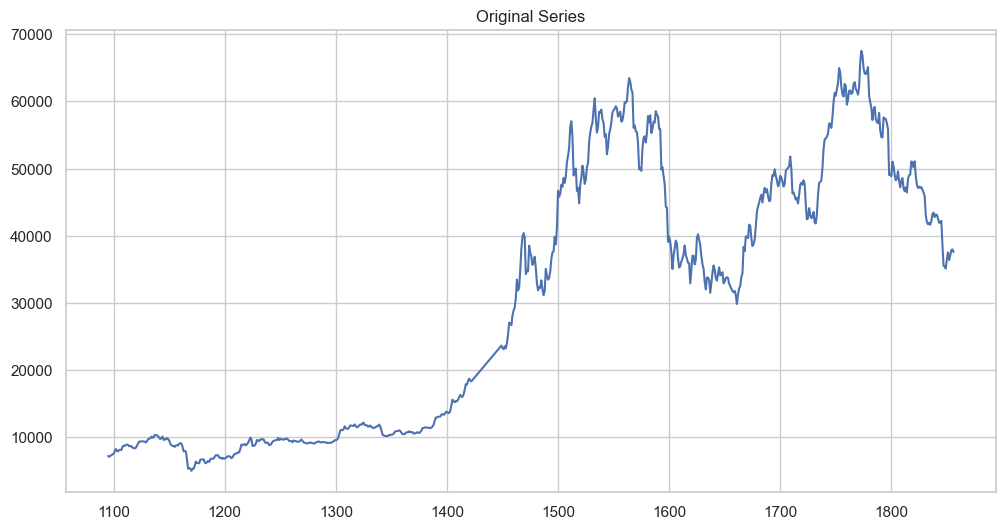

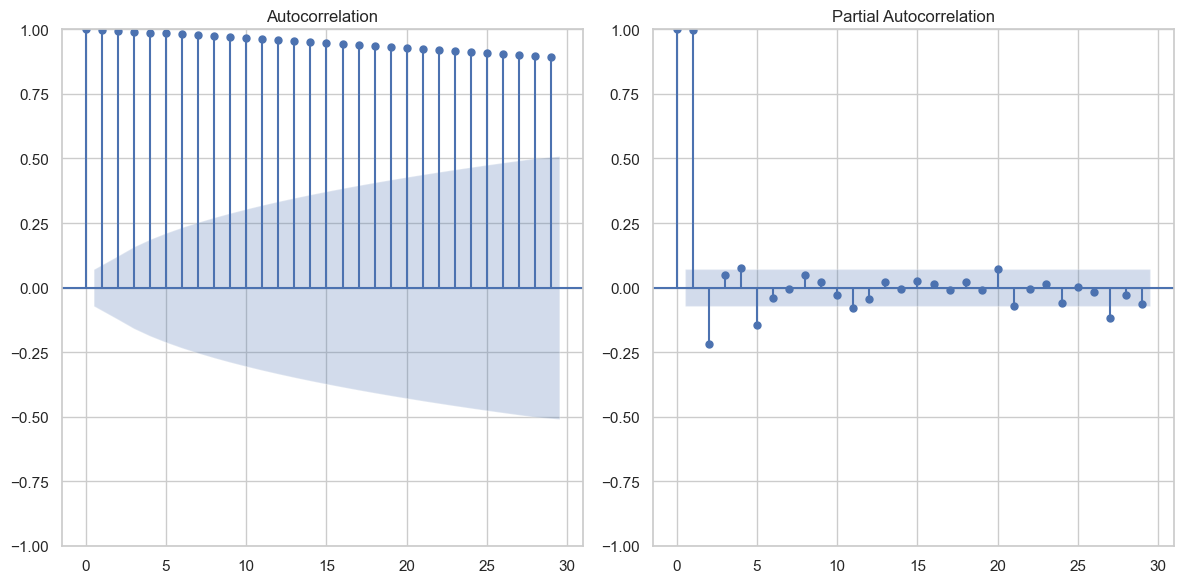

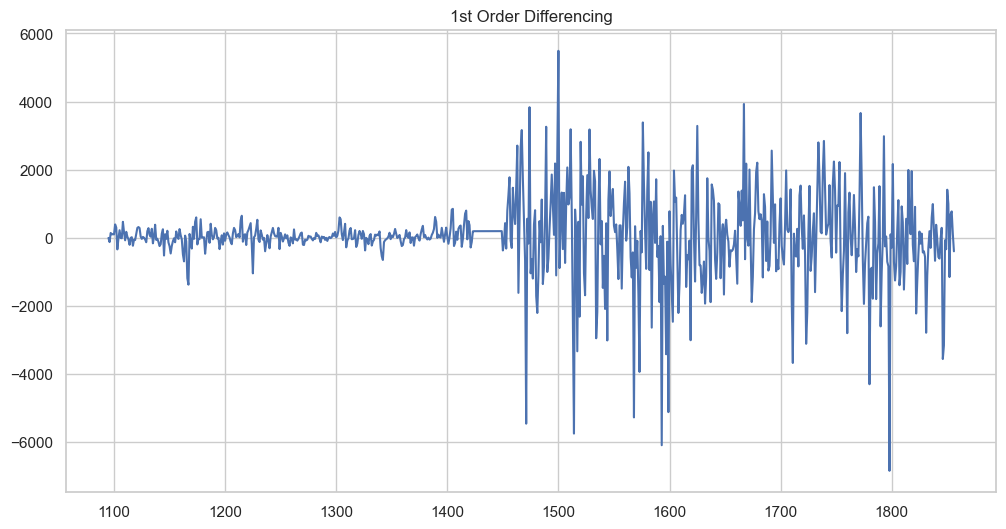

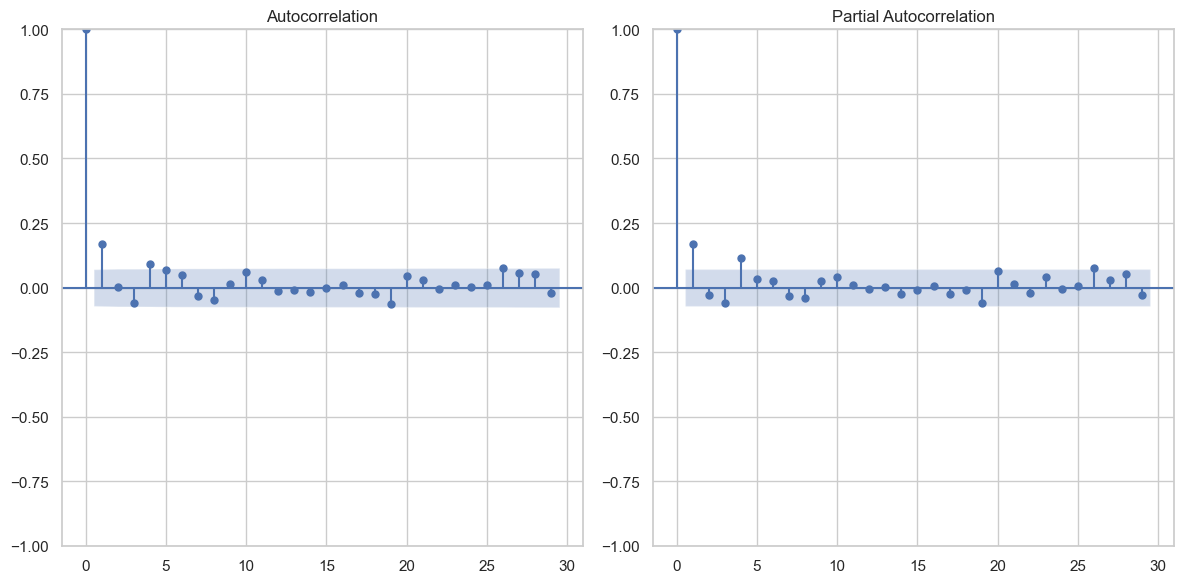

In [239]:
# Since p-value is greater than the significance level (0.05) do some DIFFERENCING
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 6))

# Original Series
ax.plot(df['close'])
ax.set_title('Original Series')
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 6))
plot_acf(df['close'], ax=ax[0])
plot_pacf(df['close'], ax=ax[1])

fig.tight_layout()
fig.show()

# 1st differencing
df['close_diff_1'] = np.append([0], np.diff(df['close']))
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 6))
ax.plot(df['close_diff_1'])
ax.set_title('1st Order Differencing')

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 6))

plot_acf(df['close_diff_1'], ax=ax[0])
plot_pacf(df['close_diff_1'], ax=ax[1])

fig.tight_layout()
fig.show()

In [240]:
# Create dataset
univariate_df = df[['date', 'close']].copy()

close_only_df = univariate_df.filter(['close'])

dataset = close_only_df.values

In [241]:
# Create train/test set
train_size = int(0.7 * len(df))
test_size = len(df) - train_size

train, test = dataset[:train_size, :], dataset[train_size:, :]

print("Train size: ", len(train), " test size: ", len(test))

Train size:  533  test size:  229


/var/folders/5d/h_8336656hb0sql9hqtn3m400000gn/T/ipykernel_72170/3870271062.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax.plot(univariate_df['date'][:train_size], train, label="Train data")
/var/folders/5d/h_8336656hb0sql9hqtn3m400000gn/T/ipykernel_72170/3870271062.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax.plot(univariate_df['date'][train_size:], test, label="Test data")
/var/folders/5d/h_8336656hb0sql9hqtn3m400000gn/T/ipykernel_72170/3870271062.py:8: UserWa

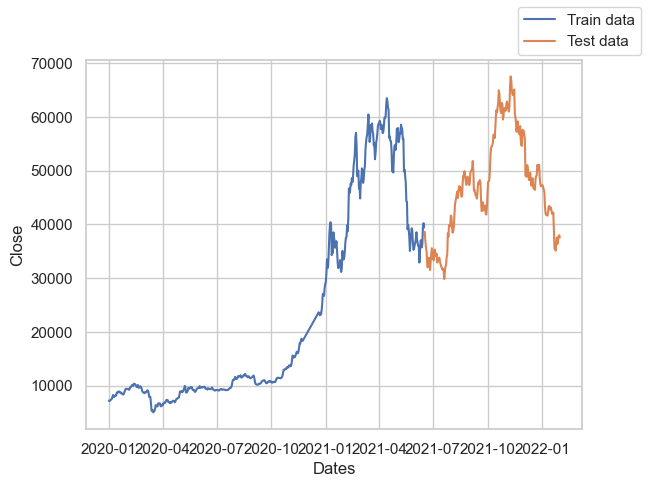

In [242]:
fig, ax = plt.subplots()

ax.set_xlabel("Dates")
ax.set_ylabel("Close")
ax.plot(univariate_df['date'][:train_size], train, label="Train data")
ax.plot(univariate_df['date'][train_size:], test, label="Test data")
fig.legend()
fig.show()

In [243]:
# Building the model

# ARIMA -> p=1, d=1 (1st degree differencing required), q=1
predictions = list()
history = [x for x in train]
for index in range(len(test)):
    # Make predictions along the way
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[index]
    # Rolling Forecast ARIMA
    history.append(obs)

In [244]:
# Calculate metrics
score_mae = mean_absolute_error(test, predictions)
score_rmse =  math.sqrt(mean_squared_error(test, predictions))
score_r2 = r2_score(test, predictions)

print("RMSE: {}".format(score_rmse))
print("R2: {}".format(score_r2))

RMSE: 1315.3547350831502
R2: 0.9806401450295433


Text(0, 0.5, 'Close')

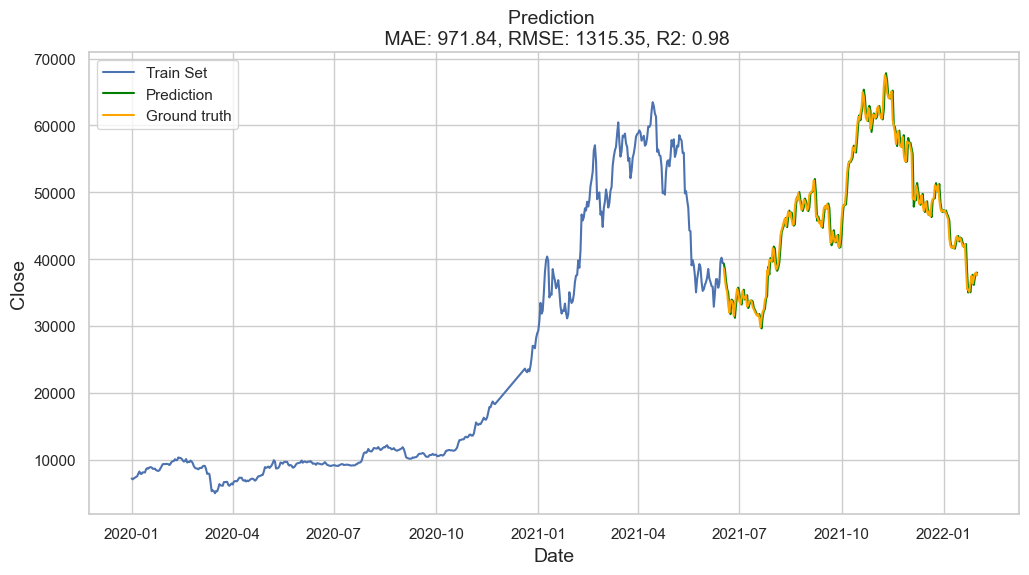

In [245]:
x_train_ticks = univariate_df.head(train_size)['date']
y_train = univariate_df.head(train_size)['close']
x_test_ticks = univariate_df.tail(test_size)['date']
y_test = univariate_df.tail(test_size)['close']

fig, ax = plt.subplots(1, figsize=(12, 6))
sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set')
sns.lineplot(x=x_test_ticks, y=predictions, ax=ax, color='green', label='Prediction')
sns.lineplot(x=x_test_ticks, y=y_test, ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}, R2: {score_r2:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Close', fontsize=14)

In [246]:
model = ARIMA(train, order=(1, 1, 1), trend='t')
model_fit = model.fit()

In [247]:
forecast = model_fit.get_forecast(len(test))
yhat = forecast.predicted_mean
conf = forecast.conf_int(alpha=0.05)

In [248]:
lower_confidence = conf[:, 0]
upper_confidence = conf[:, 1]

In [249]:
# Calculate metrics
score_mae = mean_absolute_error(test, yhat)
score_rmse =  math.sqrt(mean_squared_error(test, yhat))
score_r2 = r2_score(test, yhat)

print("RMSE: {}".format(score_rmse))
print("R2: {}".format(score_r2))

RMSE: 8598.476178000867
R2: 0.1727070958885254


Text(0, 0.5, 'Close')

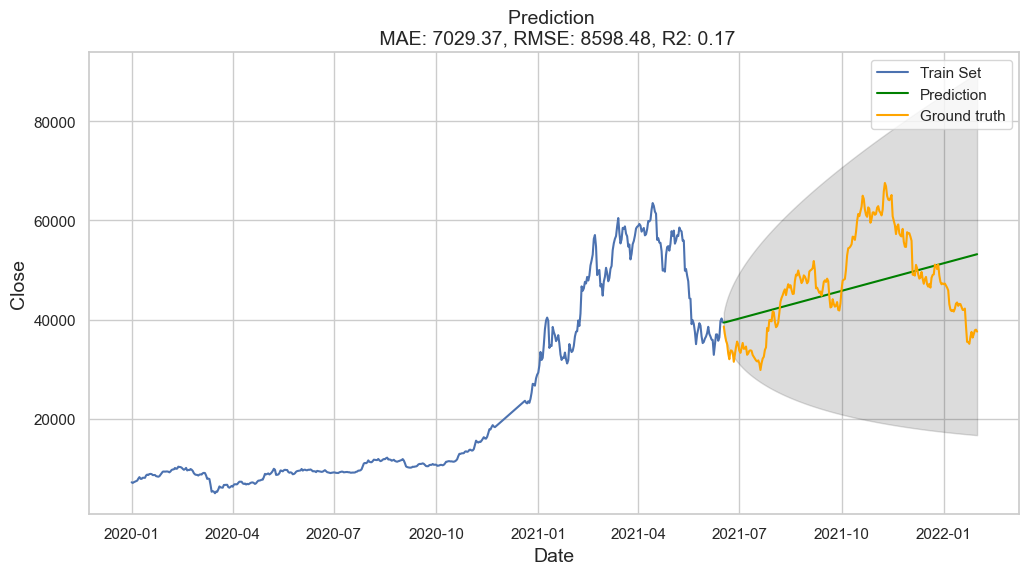

In [250]:
x_train_ticks = univariate_df.head(train_size)['date']
y_train = univariate_df.head(train_size)['close']
x_test_ticks = univariate_df.tail(test_size)['date']
y_test = univariate_df.tail(test_size)['close']

fig, ax = plt.subplots(1, figsize=(12, 6))
sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set')
sns.lineplot(x=x_test_ticks, y=yhat, ax=ax, color='green', label='Prediction')
sns.lineplot(x=x_test_ticks, y=y_test, ax=ax, color='orange', label='Ground truth')
ax.fill_between(x_test_ticks, lower_confidence, upper_confidence, color='k', alpha=.15, label="95 confidence band")

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}, R2: {score_r2:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Close', fontsize=14)